In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [2]:
dataset = pd.read_csv('../../data/GH_complete_labeled_issues_prs - preprocessed.csv', encoding='utf-8', 
                      na_filter=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152151 entries, 0 to 152150
Data columns (total 2 columns):
description    152151 non-null object
label          152151 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [3]:
from collections import Counter

dataset = dataset[dataset.label != 0]
texts = dataset['description'].tolist()
labels = dataset['label'].tolist()

print('Before:', Counter(labels))
labels = [0 if item == 1 else 1 for item in labels]
print('After:', Counter(labels))

Before: Counter({1: 22572, 2: 671})
After: Counter({0: 22572, 1: 671})


In [4]:
from sklearn.model_selection import train_test_split

train_text, test_text, train_labels, test_labels = train_test_split(texts, labels, 
                                                                    test_size=0.25, random_state=SEED)
len(train_text), len(test_text)

(17432, 5811)

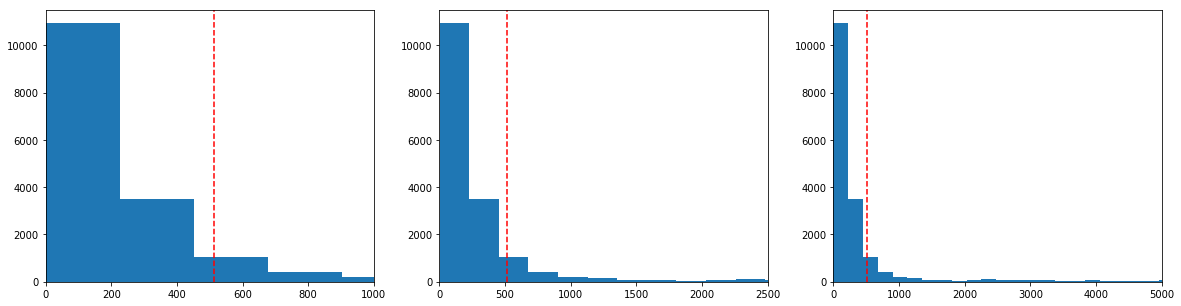

In [5]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(train_doc_lens, bins=100)
ax[0].set_xlim([0, 1000])
ax[0].axvline(512, linestyle='--', color='r')

ax[1].hist(train_doc_lens, bins=100)
ax[1].set_xlim([0, 2500])
ax[1].axvline(512, linestyle='--', color='r')

ax[2].hist(train_doc_lens, bins=100)
ax[2].set_xlim([0, 5000])
ax[2].axvline(512, linestyle='--', color='r')

In [6]:
Counter([1 if ln > 512 else 0 for ln in train_doc_lens])

Counter({0: 14826, 1: 2606})

In [7]:
from utils import bert_text_processor as btp

W0722 13:44:52.435805 140496512571200 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [8]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "models/model_assets/gokube-phase2/base_bert_tfhub_models/bert_uncased_L12_H768_A12"
MAX_SEQ_LENGTH = 512

In [9]:
# process text data
btp_train = btp.BertTextProcessor(tf_session=sess, 
                                  bert_model_path=BERT_PATH, 
                                  max_seq_length=MAX_SEQ_LENGTH)
btp_train.create_bert_tokenizer()
btp_train.convert_text_to_input_examples(train_text, train_labels)
btp_train.convert_examples_to_features()


btp_test = btp.BertTextProcessor(tf_session=sess, 
                                 bert_model_path=BERT_PATH, 
                                 max_seq_length=MAX_SEQ_LENGTH)
btp_test.create_bert_tokenizer()
btp_test.convert_text_to_input_examples(test_text)
btp_test.convert_examples_to_features()

Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 13:44:56.421277 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 17432it [00:00, 577720.15it/s]
Converting examples to features:   0%|          | 0/17432 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 17432/17432 [05:04<00:00, 57.32it/s] 


Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 13:50:05.891310 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 5811it [00:00, 580671.38it/s]
Converting examples to features:   0%|          | 0/5811 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 5811/5811 [01:35<00:00, 61.05it/s] 


In [10]:
from models import bert_cve_classifier as bcvec

In [11]:
# load pre-trained base BERT model
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 13:51:45.847110 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


In [12]:
bc.model_estimator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [13]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(btp_train.labels.ravel()),
                                                  btp_train.labels.ravel())
class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2
class_weights

{0: 0.5149474181732246, 1: 34.45059288537549}

In [14]:
modelckpt_cb = tf.keras.callbacks.ModelCheckpoint('bert_cve75_weights-ep:{epoch:02d}-trn_loss:{loss:.3f}-trn_acc:{acc:.3f}-val_loss:{val_loss:.3f}-val_acc:{val_acc:.3f}.h5', 
                                        save_weights_only=True, period=1, verbose=1)

In [15]:
btp.initialize_vars(sess)

In [16]:
history = bc.model_estimator.fit(x=[btp_train.input_ids, 
                                    btp_train.input_masks, 
                                    btp_train.segment_ids],
                                 y=train_labels,
                                 validation_split=0.1,
                                 epochs=5,
                                 batch_size=15,
                                 class_weight=class_weights,
                                 callbacks=[modelckpt_cb],
                                 verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15688 samples, validate on 1744 samples
Epoch 1/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.3956 - acc: 0.8882
Epoch 00001: saving model to bert_cve75_weights-ep:01-trn_loss:0.395-trn_acc:0.888-val_loss:0.188-val_acc:0.938.h5
15688/15688 [==============================] - 2112s 135ms/step - loss: 0.3954 - acc: 0.8882 - val_loss: 0.1878 - val_acc: 0.9381
Epoch 2/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.1722 - acc: 0.9574
Epoch 00002: saving model to bert_cve75_weights-ep:02-trn_loss:0.172-trn_acc:0.957-val_loss:0.164-val_acc:0.978.h5
15688/15688 [==============================] - 2105s 134ms/step - loss: 0.1721 - acc: 0.9575 - val_loss: 0.1639 - val_acc: 0.9782
Epoch 3/5
15675/15688 [============================>.] - ETA: 1s - loss: 0.1063 - acc: 0.9715
Epoch 00003: saving model to bert_cve75_weights-ep:03-trn_loss:0.106-trn_acc:0.971-val_loss:0.173-val_acc:0.963.h5
15688/15688 [==============================] - 2106s 134ms/step 

In [18]:
import gc
del bc
gc.collect()

330

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_weights-ep:01-trn_loss:0.395-trn_acc:0.888-val_loss:0.188-val_acc:0.938.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 19:47:00.222070 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 281s 48ms/step


In [22]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5646
           1       0.29      0.86      0.43       165

    accuracy                           0.94      5811
   macro avg       0.64      0.90      0.70      5811
weighted avg       0.98      0.94      0.95      5811

[[5295  351]
 [  23  142]]


In [23]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_weights-ep:02-trn_loss:0.172-trn_acc:0.957-val_loss:0.164-val_acc:0.978.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 19:53:59.982009 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 286s 49ms/step


In [24]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5646
           1       0.54      0.78      0.64       165

    accuracy                           0.97      5811
   macro avg       0.77      0.88      0.81      5811
weighted avg       0.98      0.97      0.98      5811

[[5536  110]
 [  37  128]]


In [25]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_weights-ep:03-trn_loss:0.106-trn_acc:0.971-val_loss:0.173-val_acc:0.963.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:01:18.679967 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 287s 49ms/step


In [26]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5646
           1       0.43      0.83      0.57       165

    accuracy                           0.96      5811
   macro avg       0.71      0.90      0.78      5811
weighted avg       0.98      0.96      0.97      5811

[[5467  179]
 [  28  137]]


In [27]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_weights-ep:04-trn_loss:0.053-trn_acc:0.988-val_loss:0.244-val_acc:0.982.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:10:36.298776 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 287s 49ms/step


In [28]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5646
           1       0.63      0.80      0.70       165

    accuracy                           0.98      5811
   macro avg       0.81      0.89      0.85      5811
weighted avg       0.98      0.98      0.98      5811

[[5567   79]
 [  33  132]]


In [30]:
del bc
gc.collect()
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve75_weights-ep:05-trn_loss:0.052-trn_acc:0.990-val_loss:0.288-val_acc:0.983.h5')
test_predictions = bc.model_estimator.predict(x=[btp_test.input_ids, 
                                                 btp_test.input_masks, 
                                                 btp_test.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:21:08.983664 140496512571200 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
5811/5811 [==============================] - 291s 50ms/step


In [31]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=test_labels, y_pred=test_preds))
print(confusion_matrix(y_true=test_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5646
           1       0.74      0.70      0.72       165

    accuracy                           0.98      5811
   macro avg       0.87      0.85      0.86      5811
weighted avg       0.98      0.98      0.98      5811

[[5606   40]
 [  49  116]]


In [32]:
del bc
gc.collect()

562

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import bert_text_processor as btp
from models import bert_cve_classifier as bcvec
from sklearn.utils import class_weight
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

W0722 20:47:47.210887 140719148209984 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
dataset = pd.read_csv('../../data/GH_complete_labeled_issues_prs - preprocessed.csv', encoding='utf-8', 
                      na_filter=False)
dataset = dataset[dataset.label != 0]
texts = dataset['description'].tolist()
labels = dataset['label'].tolist()

print('Before:', Counter(labels))
labels = [0 if item == 1 else 1 for item in labels]
print('After:', Counter(labels))

Before: Counter({1: 22572, 2: 671})
After: Counter({0: 22572, 1: 671})


In [3]:
train_text, test_text, train_labels, test_labels = train_test_split(texts, labels, 
                                                                    test_size=1e-6, random_state=SEED)
len(train_text), len(test_text)

(23242, 1)

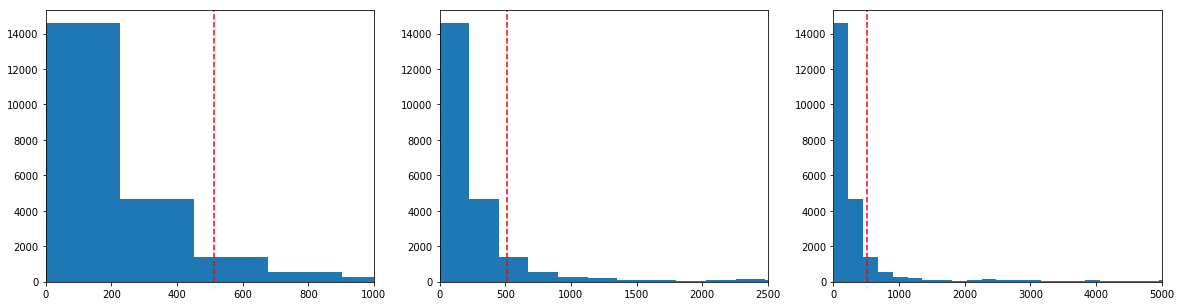

In [4]:
train_doc_lens = [len(doc.split(' ')) for doc in train_text]
f, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(train_doc_lens, bins=100)
ax[0].set_xlim([0, 1000])
ax[0].axvline(512, linestyle='--', color='r')

ax[1].hist(train_doc_lens, bins=100)
ax[1].set_xlim([0, 2500])
ax[1].axvline(512, linestyle='--', color='r')

ax[2].hist(train_doc_lens, bins=100)
ax[2].set_xlim([0, 5000])
ax[2].axvline(512, linestyle='--', color='r')

In [5]:
Counter([1 if ln > 512 else 0 for ln in train_doc_lens])

Counter({0: 19812, 1: 3430})

In [6]:
# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
BERT_PATH = "models/model_assets/gokube-phase2/base_bert_tfhub_models/bert_uncased_L12_H768_A12"
MAX_SEQ_LENGTH = 512

In [7]:
# process text data
btp_train = btp.BertTextProcessor(tf_session=sess, 
                                  bert_model_path=BERT_PATH, 
                                  max_seq_length=MAX_SEQ_LENGTH)
btp_train.create_bert_tokenizer()
btp_train.convert_text_to_input_examples(train_text, train_labels)
btp_train.convert_examples_to_features()

Loading Base BERT Model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:48:03.283648 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore
Converting text to examples: 23242it [00:00, 605558.47it/s]
Converting examples to features:   0%|          | 0/23242 [00:00<?, ?it/s]

Loading BERT WordPiece Tokenizer
Creating Input Examples from data
Creating BERT Input Features from Input Examples


Converting examples to features: 100%|██████████| 23242/23242 [06:26<00:00, 60.11it/s] 


In [8]:
# load pre-trained base BERT model
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.model_estimator.summary()

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0722 20:54:36.610916 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(btp_train.labels.ravel()),
                                                  btp_train.labels.ravel())
class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2
class_weights

{0: 0.5148642062823978, 1: 34.63785394932936}

In [10]:
modelckpt_cb = tf.keras.callbacks.ModelCheckpoint('bert_cve99iter2_weights-ep:{epoch:02d}-trn_loss:{loss:.3f}-trn_acc:{acc:.3f}-val_loss:{val_loss:.3f}-val_acc:{val_acc:.3f}.h5', 
                                        save_weights_only=True, period=1, verbose=1)

In [11]:
btp.initialize_vars(sess)

In [12]:
history = bc.model_estimator.fit(x=[btp_train.input_ids, 
                                    btp_train.input_masks, 
                                    btp_train.segment_ids],
                                 y=train_labels,
                                 validation_split=0.1,
                                 epochs=5,
                                 batch_size=15,
                                 class_weight=class_weights,
                                 callbacks=[modelckpt_cb],
                                 verbose=1
)

/home/redanalyze/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20917 samples, validate on 2325 samples
Epoch 1/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.3755 - acc: 0.9063
Epoch 00001: saving model to bert_cve99_weights-ep:01-trn_loss:0.375-trn_acc:0.906-val_loss:0.278-val_acc:0.984.h5
20917/20917 [==============================] - 2794s 134ms/step - loss: 0.3754 - acc: 0.9063 - val_loss: 0.2784 - val_acc: 0.9837
Epoch 2/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.1938 - acc: 0.9527
Epoch 00002: saving model to bert_cve99_weights-ep:02-trn_loss:0.194-trn_acc:0.953-val_loss:0.217-val_acc:0.948.h5
20917/20917 [==============================] - 2783s 133ms/step - loss: 0.1939 - acc: 0.9527 - val_loss: 0.2167 - val_acc: 0.9475
Epoch 3/5
20910/20917 [============================>.] - ETA: 0s - loss: 0.1114 - acc: 0.9764
Epoch 00003: saving model to bert_cve99_weights-ep:03-trn_loss:0.111-trn_acc:0.976-val_loss:0.308-val_acc:0.980.h5
20917/20917 [==============================] - 2776s 133ms/step 

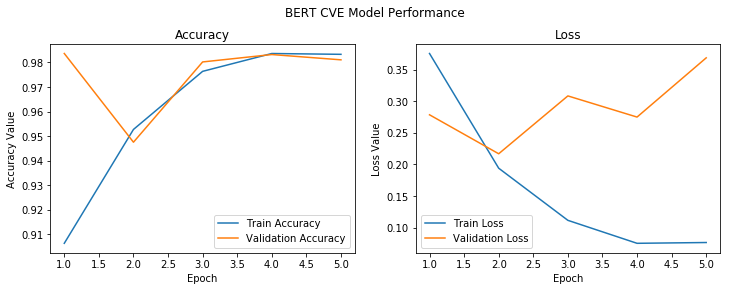

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('BERT CVE Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.2)

epochs = list(range(1,6))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
import gc
del bc
gc.collect()

5497

In [20]:
bc = bcvec.BERTClassifier(bert_model_path=BERT_PATH, 
                          max_seq_length=MAX_SEQ_LENGTH)
bc.build_model_architecture()
bc.load_model_weights(model_weights_path='./bert_cve99_weights-ep:04-trn_loss:0.075-trn_acc:0.984-val_loss:0.275-val_acc:0.983.h5')
test_predictions = bc.model_estimator.predict(x=[btp_train.input_ids, 
                                                 btp_train.input_masks, 
                                                 btp_train.segment_ids],
                                                 batch_size=256,
                                              verbose=1)

Build BERT Classifier CVE Model Architecture
Loading Base BERT Model
Trainable layers: 199
Non Trainable layers: 5
Constructing Base BERT architecture
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0723 06:14:37.935068 140719148209984 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Loading BERT Classifier CVE Model Weights
23242/23242 [==============================] - 1136s 49ms/step


In [24]:
test_preds = test_predictions.ravel()
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]
print('Performance Report:')
print(classification_report(y_true=train_labels, y_pred=test_preds))
print(confusion_matrix(y_true=train_labels, y_pred=test_preds))

Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     22571
           1       0.84      0.96      0.89       671

    accuracy                           0.99     23242
   macro avg       0.92      0.97      0.94     23242
weighted avg       0.99      0.99      0.99     23242

[[22445   126]
 [   30   641]]
